In [1]:
import torch
import sys
from torchviz import make_dot
import numpy as np

In [2]:
sys.path.append('../src')
sys.path.append('../src/ml_variants/unet/pipelines/training/')

In [4]:
from ml_variants.unet.pipelines.training.steps.trainers import Sat2Rad

In [5]:
model = Sat2Rad()

cpu


In [6]:
input = torch.ones((2, 16, 16))

In [7]:
input

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1.,

In [8]:
# yhat = model(np.zeros((1, 1)))

In [9]:
myConvLstm = ConvLSTM(
    input_size=(16, 16),
    input_dim=2,
    hidden_dim=[1,1,1],
    kernel_size=(3,3),
    num_layers=3
  )

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_21014/4064652177.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_21014/4064652177.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'ConvLSTM' is not defined

In [10]:
myConvLstm(input, myConvLstm.get_init_states(1, cuda=False))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_21014/2773321791.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_21014/2773321791.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'myConvLstm' is not defined

In [3]:
import os
from util.parse_time import *
import matplotlib.pyplot as plt
from ml_variants.conv_classes.pipelines.training.steps.trainers import Sat2Rad as ConvClass

In [11]:
model = Sat2Rad.load_from_checkpoint("../src/ml_variants/unet/pipelines/training/lightning_logs/version_30/checkpoints/epoch=39-step=105720.ckpt")

cpu


In [4]:
conv = ConvClass.load_from_checkpoint('../src/ml_variants/conv_classes/pipelines/training/lightning_logs/version_96/checkpoints/epoch=3-step=2120.ckpt')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_23211/918310952.py:1 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_23211/918310952.py'                         │
│                                                                                                  │
│ /home/mark/miniconda3/envs/torch/lib/python3.10/site-packages/lightning/pytorch/core/module.py:1 │
│ 531 in load_from_checkpoint                                                                      │
│                                                                                                  │
│   1528 │   │   │   pretrained_model.freeze()                                                     │
│   1529 │   │   │   y_hat = pretrained_model(x)                                                   │
│   1530 │   │   """                                                                               │
│ ❱ 1531 │   │   loaded = _load_from_checkpoint(                                                   │
│   1532 │   │   │   cls,                                                                          │
│   1533 │   │   │   checkpoint_path,                                                              │
│   1534 │   │   │   map_location,                                                                 │
│                                                                                                  │
│ /home/mark/miniconda3/envs/torch/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:8 │
│ 8 in _load_from_checkpoint                                                                       │
│                                                                                                  │
│    85 │   if issubclass(cls, pl.LightningDataModule):                                            │
│    86 │   │   return _load_state(cls, checkpoint, **kwargs)                                      │
│    87 │   if issubclass(cls, pl.LightningModule):                                                │
│ ❱  88 │   │   storage = _load_state(cls, checkpoint, strict=strict, **kwargs)                    │
│    89 │   │   state_dict = checkpoint["state_dict"]                                              │
│    90 │   │   if not state_dict:                                                                 │
│    91 │   │   │   raise ValueError(f"The state dict in {checkpoint_path!r} contains no paramet   │
│                                                                                                  │
│ /home/mark/miniconda3/envs/torch/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:1 │
│ 54 in _load_state                                                                                │
│                                                                                                  │
│   151 │                                                                                          │
│   152 │   # load the state_dict on the model automatically                                       │
│   153 │   assert strict is not None                                                              │
│ ❱ 154 │   keys = obj.load_state_dict(checkpoint["state_dict"], strict=strict)                    │
│   155 │                                                                                          │
│   156 │   if not strict:                                                                         │
│   157 │   │   if keys.missing_keys:                                                              │
│                                                                                                  │
│ /home/mark/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/module.py:2041 in │
│ load_state_dict                                            

In [123]:
def loadFile(file: str):
    arr = np.load(file)
    return addTimeDim(arr, file)


def addTimeDim(array: np.ndarray, time: str):
    now = parseTime(time).hour / 24
    times = np.array([now]).repeat(256 * 256).reshape((1, 256, 256))
    return np.concatenate((array, times), axis=0)

In [5]:
start = 308

In [6]:
originals = order_based_on_file_timestamp(os.listdir('../data/preprocessed/satellite/'))[start:start+8]

In [7]:
radars = order_based_on_file_timestamp(os.listdir('../data/preprocessed/radar'))

In [8]:
timesRadar = [parseTime(s) for s in radars]

In [9]:
originals[0]

'MSG4-SEVI-MSG15-0100-NA-20230305062743.353000000Z-NA.npy'

In [10]:
start, end = get_next_sequence(8, originals[0], radars)

In [11]:
radarimg = [np.load(f"../data/preprocessed/radar/{x}") for x in radars[start:end]]

In [12]:
times = [parseTime(s) for s in originals]

In [13]:
x = [loadFile(f"../data/preprocessed/satellite/{x}") for x in originals]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_23211/3111984669.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_23211/3111984669.py'                        │
│                                                                                                  │
│ /tmp/ipykernel_23211/3111984669.py:1 in <listcomp>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_23211/3111984669.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'loadFile' is not defined

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_23211/4274307147.py:2 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_23211/4274307147.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'x' is not defined

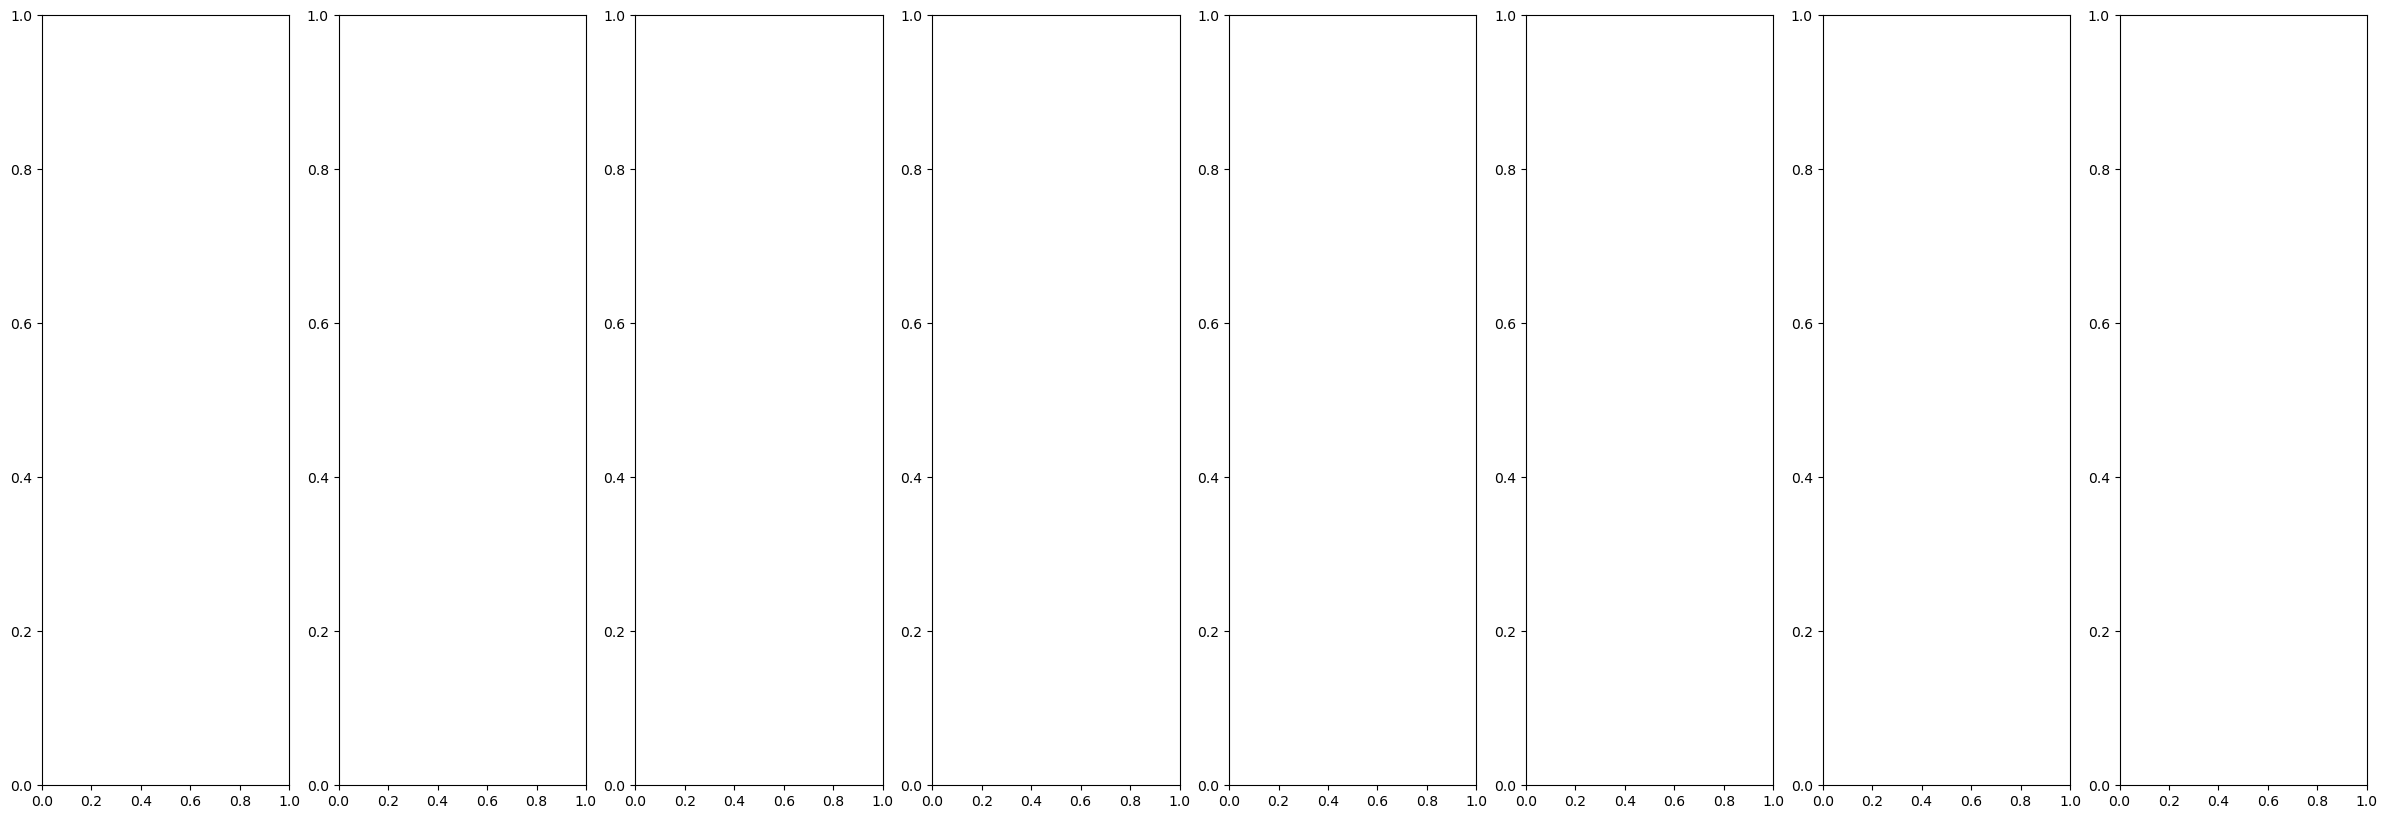

In [14]:
f, a = plt.subplots(1, 8, figsize=(30, 10))
for i, dd in enumerate(x):
    a[i].imshow(dd[0])
    a[i].grid(True)
    a[i].axis('off')
    a[i].set_title(f"{times[i]}", color='white', font="monospace")

f.set_facecolor("black")

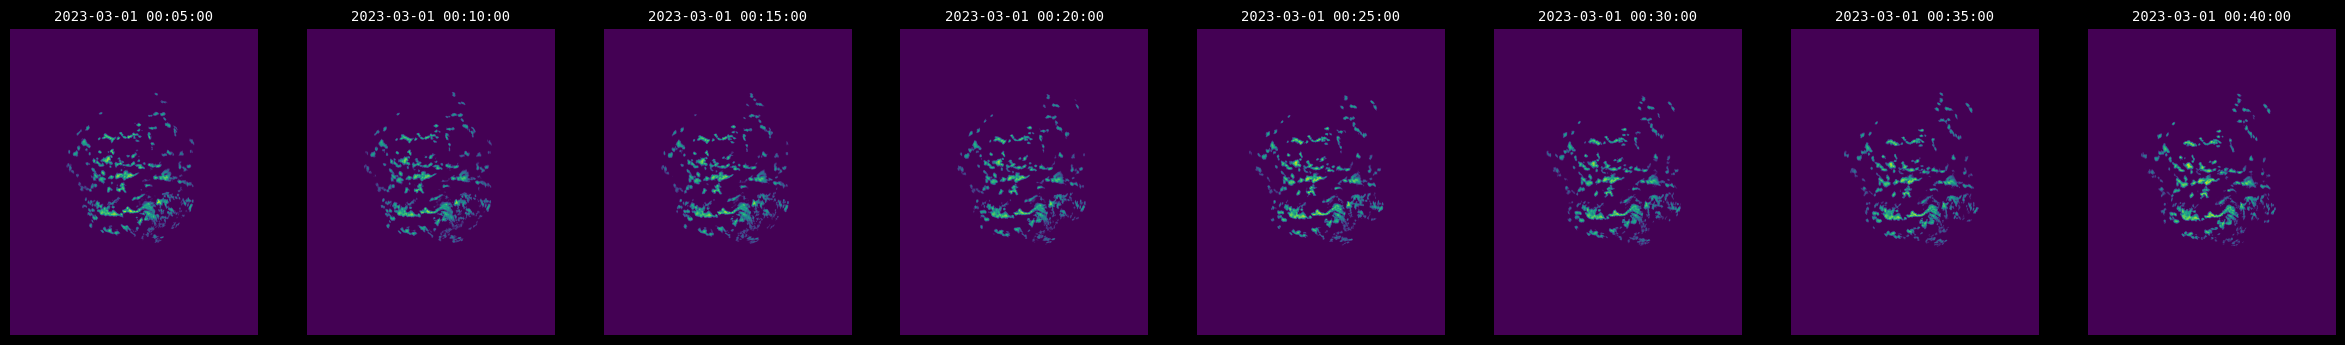

In [156]:
f, a = plt.subplots(1, 8, figsize=(30, 10))

for i, rest in enumerate(radarimg):
    a[i].imshow(rest)
    a[i].grid(True)
    a[i].axis('off')
    a[i].set_title(f"{timesRadar[i]}", color='white', font="monospace")

f.set_facecolor("black")

In [157]:
x = torch.from_numpy(np.array(x)).float().cuda()

In [158]:
test = (x, torch.zeros(1).cuda())

In [159]:
model.cuda()

Sat2Rad(
  (unet): UNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (groupnorm): GroupNorm(1, 12, eps=1e-05, affine=True)
            (conv): Conv3d(12, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (SingleConv2): SingleConv(
            (groupnorm): GroupNorm(1, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
        )
      )
      (1): Encoder(
        (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (groupnorm): GroupNorm(1, 64, eps=1e-05, affine=True)
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), b

In [160]:
model.eval()

with torch.no_grad():
    y_hat = model(test)

In [152]:
next(model.parameters()).is_cuda # returns a boolean

True

In [164]:
y_hat.shape

torch.Size([1, 8, 256, 256])

In [168]:
tttt = torch.softmax(y_hat, dim=1)

In [179]:
tttt.shape

torch.Size([1, 8, 256, 256])

In [181]:
torch.sum(tttt[0,:,0,0])

tensor(1., device='cuda:0')

In [182]:
pp = torch.argmax(tttt, axis=1)

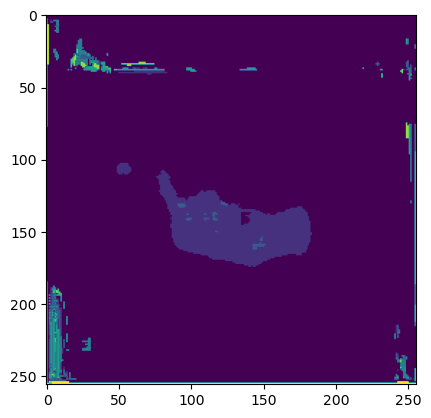

In [186]:
plt.imshow(pp.cpu().detach()[0])